In [1]:
import tensorflow as tf
import numpy as np
import cv2
from keras.utils import Sequence
from keras.applications.mobilenet_v3 import preprocess_input
from glob import glob
import os
from sklearn.model_selection import train_test_split

from keras.applications import MobileNetV3Large
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.optimizers import AdamW
from keras.losses import CategoricalCrossentropy
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.metrics import TopKCategoricalAccuracy
from keras.layers import RandomRotation
from keras.callbacks import LearningRateScheduler



import math
import json


import re
print(tf.__version__)
import tensorflow_probability as tfp
tfd = tfp.distributions


2.15.0




In [30]:
# Load class names
with open("food-101/meta/classes.txt", "r") as file:
    classes = [line.strip() for line in file]

# Read image paths
with open("food-101/meta/train.txt", "r") as file:
    train_paths = [line.strip() for line in file]

with open("food-101/meta/test.txt", "r") as file:
    test_paths = [line.strip() for line in file]

# Helper function to convert label format
def to_snake_case(name):
    return name.replace(" ", "_").lower()

# Convert paths to full paths
train_full_paths = [os.path.join("food-101/images", p + ".jpg") for p in train_paths]
train_labels = [to_snake_case(p.split("/")[0]) for p in train_paths]

test_full_paths = [os.path.join("food-101/images", p + ".jpg") for p in test_paths]
test_labels = [to_snake_case(p.split("/")[0]) for p in test_paths]

# Map labels to indices
class_to_index = {cls: idx for idx, cls in enumerate(classes)}
train_label_indices = [class_to_index[label] for label in train_labels]
test_label_indices = [class_to_index[label] for label in test_labels]

# ✂️ Split 80% train, 20% val
train_paths_split, val_paths_split, train_labels_split, val_labels_split = train_test_split(
    train_full_paths, train_label_indices, test_size=0.2, stratify=train_label_indices, random_state=42
)

# Constants
IMG_SIZE = 224
BATCH_SIZE = 64
NUM_CLASSES = len(classes)

rotation_layer = RandomRotation(factor=0.014)

# Augmentation function
def augment_image(img):
    img = rotation_layer(img)
    img = tf.image.resize_with_crop_or_pad(img, 256, 256)
    img = tf.image.random_crop(img, size=[224, 224, 3])    
    img = tf.image.random_flip_left_right(img)            
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.9, 1.1)
    img = tf.image.random_hue(img, 0.08)
    img = tf.clip_by_value(img, 0.0, 255.0)
    return img

# Preprocess each sample
def process_example(path, label, augment=False):
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img_raw, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    if augment:
        img = augment_image(img)
    img = preprocess_input(img)
    label = tf.one_hot(label, NUM_CLASSES)
    return img, label

# Dataset creation function
def create_dataset(paths, labels, augment=False, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths))
    ds = ds.map(lambda x, y: process_example(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

val_ds = create_dataset(val_paths_split, val_labels_split, augment=False, shuffle=False)
test_ds = create_dataset(test_full_paths, test_label_indices, augment=False, shuffle=False)

In [31]:
def get_cosine_annealing_with_restarts(
    initial_lr=1e-3,
    min_lr=1e-7,
    warmup_epochs=5,
    T_0=20,
    T_mult=1
):
    def scheduler(epoch, lr):

        # Warmup phase
        if epoch < warmup_epochs:
            return float(initial_lr * (epoch + 1) / warmup_epochs)

        # Cosine annealing with restarts
        t = epoch - warmup_epochs  # Epochs after warmup
        T_i = T_0
        cumulative = 0

        while t >= T_i:
            t -= T_i
            cumulative += T_i
            T_i *= T_mult

        progress = t / T_i
        cosine_decay = 0.5 * (1 + math.cos(math.pi * progress))
        return float(min_lr + (initial_lr - min_lr) * cosine_decay)

    return scheduler

In [32]:
def apply_cutmix(ds, alpha=1.0):
    def cutmix(images, labels):
        batch_size = tf.shape(images)[0]
        indices = tf.random.shuffle(tf.range(batch_size))
        image1, image2 = images, tf.gather(images, indices)
        label1, label2 = labels, tf.gather(labels, indices)

        h = tf.shape(images)[1]
        w = tf.shape(images)[2]
        lam = tfd.Beta(alpha, alpha).sample()

        cut_rat = tf.math.sqrt(1. - lam)
        cut_w = tf.cast(tf.cast(w, tf.float32) * cut_rat, tf.int32)
        cut_h = tf.cast(tf.cast(h, tf.float32) * cut_rat, tf.int32)

        cx = tf.random.uniform([], 0, w, dtype=tf.int32)
        cy = tf.random.uniform([], 0, h, dtype=tf.int32)

        x1 = tf.clip_by_value(cx - cut_w // 2, 0, w)
        y1 = tf.clip_by_value(cy - cut_h // 2, 0, h)
        x2 = tf.clip_by_value(cx + cut_w // 2, 0, w)
        y2 = tf.clip_by_value(cy + cut_h // 2, 0, h)

        def replace_patch(img1, img2):
            patch = img2[y1:y2, x1:x2, :]
            paddings = [[y1, h - y2], [x1, w - x2], [0, 0]]
            patch_padded = tf.pad(patch, paddings)
            mask = tf.pad(tf.ones_like(patch), paddings)
            return tf.where(mask > 0, patch_padded, img1)

        mixed_images = tf.map_fn(lambda x: replace_patch(x[0], x[1]), (image1, image2), dtype=tf.float32)

        patch_area = tf.cast((x2 - x1) * (y2 - y1), tf.float32)
        total_area = tf.cast(h * w, tf.float32)
        lam_adjusted = 1.0 - (patch_area / total_area)

        mixed_labels = lam_adjusted * label1 + (1.0 - lam_adjusted) * label2

        return mixed_images, mixed_labels

    return ds.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)


def apply_mixup(ds, alpha):
    def mixup(images, labels):
        batch_size = tf.shape(images)[0]
        indices = tf.random.shuffle(tf.range(batch_size))
        image1, image2 = images, tf.gather(images, indices)
        label1, label2 = labels, tf.gather(labels, indices)

        lam = tfd.Beta(alpha, alpha).sample()
        lam_x = tf.reshape(lam, [1, 1, 1])
        lam_y = tf.reshape(lam, [1])

        mixed_image = lam_x * image1 + (1 - lam_x) * image2
        mixed_label = lam_y * label1 + (1 - lam_y) * label2

        return mixed_image, mixed_label

    return ds.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)

In [33]:
# No Augmentation
train_ds_prep = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds = apply_cutmix(train_ds_prep, 1)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)


base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='D:\\Skripsi\\MobilNetV3-Food101-Rev-Baseline\\Model_MobileNetV3-3-CutMix.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

In [ ]:

def _erase_one_image(x, p=0.5, sl=0.02, sh=0.4, r1=0.3, random_fill=True):
    def _apply(img):
        h = tf.shape(img)[0]
        w = tf.shape(img)[1]
        c = tf.shape(img)[2]
        area = tf.cast(h * w, tf.float32)

        target_area = tf.random.uniform([], sl, sh) * area
        aspect = tf.random.uniform([], r1, 1.0 / r1)
 
        eh = tf.cast(tf.round(tf.sqrt(target_area * aspect)), tf.int32)
        ew = tf.cast(tf.round(tf.sqrt(target_area / aspect)), tf.int32)
        eh = tf.clip_by_value(eh, 1, h); ew = tf.clip_by_value(ew, 1, w)

        x1 = tf.random.uniform([], 0, h - eh + 1, dtype=tf.int32)
        y1 = tf.random.uniform([], 0, w - ew + 1, dtype=tf.int32)

        pad = [[x1, h - (x1 + eh)], [y1, w - (y1 + ew)], [0, 0]]
        mask1 = tf.pad(tf.ones([eh, ew, 1], img.dtype), pad)     
        mask  = tf.broadcast_to(mask1, [h, w, c])                   

        if random_fill:
            vmin = tf.reduce_min(img); vmax = tf.reduce_max(img)
            fill1 = tf.pad(tf.random.uniform([eh, ew, 1], vmin, vmax, dtype=img.dtype), pad)
        else:
            gray = tf.reduce_mean(img)  
            fill1 = tf.pad(tf.fill([eh, ew, 1], tf.cast(gray, img.dtype)), pad)
        fill = tf.broadcast_to(fill1, [h, w, c])

        return img * (1.0 - mask) + fill * mask

    return tf.cond(tf.random.uniform([]) < p, lambda: _apply(x), lambda: x)

def apply_random_erasing_batched(ds, p=0.5, sl=0.02, sh=0.4, r1=0.3, n=1, random_fill=True):
    def _erase_n(img):
        def body(i, im):
            im = _erase_one_image(im, p=p, sl=sl, sh=sh, r1=r1, random_fill=random_fill)
            return i+1, im
        _, out = tf.while_loop(lambda i, *_: i < n, body, (0, img))
        return out

    def _map_fn(images, labels):
        if images.dtype == tf.uint8:
            images = tf.image.convert_image_dtype(images, tf.float32) 
        else:
            images = tf.cast(images, tf.float32)

        images = tf.map_fn(_erase_n, images, fn_output_signature=tf.float32)
        return images, labels

    return ds.map(_map_fn, num_parallel_calls=tf.data.AUTOTUNE)


In [42]:
test_ds_r = apply_random_erasing_batched(test_ds, p=1)

In [10]:
# No Augmentation
train_ds_prep = create_dataset(train_paths_split, train_labels_split, augment=False)
train_ds = apply_cutmix(train_ds_prep, 1)

loss_fn = CategoricalCrossentropy(label_smoothing=0.05)


base_model = MobileNetV3Large(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(128, activation='relu')(x)
output = Dense(101, activation='softmax')(x)

checkpoint_cb = ModelCheckpoint(
    filepath='D:\\Skripsi\\MobilNetV3-Food101-Rev-Baseline\\Model_MobileNetV3-3-CutMix.keras',          
    monitor='val_accuracy',            
    mode='max',                         
    save_best_only=True,                            
    verbose=1
)

lr_scheduler = LearningRateScheduler(get_cosine_annealing_with_restarts())

model = Model(inputs=base_model.input, outputs=output)
model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history = model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=5, 
    callbacks=[checkpoint_cb, lr_scheduler]
)

total_layers = len(base_model.layers)

unfreeze_count = int(total_layers * 0.3)

for layer in base_model.layers[-unfreeze_count:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-5), 
    loss=loss_fn, 
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)

history_fine_tune = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    initial_epoch=5,
    callbacks=[checkpoint_cb, lr_scheduler]
)

combined_history = {}
for key in history.history.keys():
    combined_history[key] = history.history[key] + history_fine_tune.history[key]

with open('skripsi/history/Model_History_MobilNetV3-3-CutMix.json', 'w') as f:
    json.dump(combined_history, f)

Instructions for updating:
Use fn_output_signature instead

Epoch 1/5

947/947 [==============================] - ETA: 0s - loss: 4.0867 - accuracy: 0.1476 - top_5_accuracy: 0.3265
Epoch 1: val_accuracy improved from -inf to 0.42851, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 725s 762ms/step - loss: 4.0867 - accuracy: 0.1476 - top_5_accuracy: 0.3265 - val_loss: 2.6767 - val_accuracy: 0.4285 - val_top_5_accuracy: 0.7028 - lr: 2.0000e-04
Epoch 2/5
947/947 [==============================] - ETA: 0s - loss: 3.5324 - accuracy: 0.2851 - top_5_accuracy: 0.5414
Epoch 2: val_accuracy improved from 0.42851 to 0.52515, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 718s 757ms/step - loss: 3.5324 - accuracy: 0.2851 - top_5_accuracy: 0.5414 - val_loss: 2.2417 - val_accuracy: 0.5251 - val_top_5_accuracy: 0.7944 - lr: 4.000

TypeError: Object of type float32 is not JSON serializable

WARNING:tensorflow:From c:\Users\Lucas Salvacio\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\deprecation.py:660: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead
WARNING:tensorflow:From c:\Users\Lucas Salvacio\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\normalization\batch_normalization.py:979: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

Epoch 1/5
WARNING:tensorflow:From c:\Users\Lucas Salvacio\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\tf_utils.py:492: The name tf.ragged.RaggedTensorValue is deprecated. Please use tf.compat.v1.ragged.RaggedTensorValue instead.

947/947 [==============================] - ETA: 0s - loss: 4.0867 - accuracy: 0.1476 - top_5_accuracy: 0.3265
Epoch 1: val_accuracy improved from -inf to 0.42851, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 725s 762ms/step - loss: 4.0867 - accuracy: 0.1476 - top_5_accuracy: 0.3265 - val_loss: 2.6767 - val_accuracy: 0.4285 - val_top_5_accuracy: 0.7028 - lr: 2.0000e-04
Epoch 2/5
947/947 [==============================] - ETA: 0s - loss: 3.5324 - accuracy: 0.2851 - top_5_accuracy: 0.5414
Epoch 2: val_accuracy improved from 0.42851 to 0.52515, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 718s 757ms/step - loss: 3.5324 - accuracy: 0.2851 - top_5_accuracy: 0.5414 - val_loss: 2.2417 - val_accuracy: 0.5251 - val_top_5_accuracy: 0.7944 - lr: 4.0000e-04
Epoch 3/5
947/947 [==============================] - ETA: 0s - loss: 3.3597 - accuracy: 0.3389 - top_5_accuracy: 0.5961
Epoch 3: val_accuracy improved from 0.52515 to 0.55129, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 725s 764ms/step - loss: 3.3597 - accuracy: 0.3389 - top_5_accuracy: 0.5961 - val_loss: 2.1082 - val_accuracy: 0.5513 - val_top_5_accuracy: 0.8094 - lr: 6.0000e-04
Epoch 4/5
947/947 [==============================] - ETA: 0s - loss: 3.3156 - accuracy: 0.3506 - top_5_accuracy: 0.6080
Epoch 4: val_accuracy improved from 0.55129 to 0.56429, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 728s 768ms/step - loss: 3.3156 - accuracy: 0.3506 - top_5_accuracy: 0.6080 - val_loss: 2.0521 - val_accuracy: 0.5643 - val_top_5_accuracy: 0.8156 - lr: 8.0000e-04
Epoch 5/5
947/947 [==============================] - ETA: 0s - loss: 3.3088 - accuracy: 0.3533 - top_5_accuracy: 0.6125
Epoch 5: val_accuracy improved from 0.56429 to 0.56898, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 725s 765ms/step - loss: 3.3088 - accuracy: 0.3533 - top_5_accuracy: 0.6125 - val_loss: 2.0306 - val_accuracy: 0.5690 - val_top_5_accuracy: 0.8250 - lr: 0.0010
Epoch 6/25
947/947 [==============================] - ETA: 0s - loss: 3.1026 - accuracy: 0.4218 - top_5_accuracy: 0.6817
Epoch 6: val_accuracy did not improve from 0.56898
947/947 [==============================] - 919s 965ms/step - loss: 3.1026 - accuracy: 0.4218 - top_5_accuracy: 0.6817 - val_loss: 3.1383 - val_accuracy: 0.4407 - val_top_5_accuracy: 0.7102 - lr: 0.0010
Epoch 7/25
947/947 [==============================] - ETA: 0s - loss: 2.8351 - accuracy: 0.4990 - top_5_accuracy: 0.7538
Epoch 7: val_accuracy improved from 0.56898 to 0.58964, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 947s 999ms/step - loss: 2.8351 - accuracy: 0.4990 - top_5_accuracy: 0.7538 - val_loss: 2.0190 - val_accuracy: 0.5896 - val_top_5_accuracy: 0.8261 - lr: 9.9384e-04
Epoch 8/25
947/947 [==============================] - ETA: 0s - loss: 2.6817 - accuracy: 0.5470 - top_5_accuracy: 0.7905
Epoch 8: val_accuracy improved from 0.58964 to 0.63314, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 980s 1s/step - loss: 2.6817 - accuracy: 0.5470 - top_5_accuracy: 0.7905 - val_loss: 1.9127 - val_accuracy: 0.6331 - val_top_5_accuracy: 0.8603 - lr: 9.7553e-04
Epoch 9/25
947/947 [==============================] - ETA: 0s - loss: 2.5996 - accuracy: 0.5616 - top_5_accuracy: 0.8049
Epoch 9: val_accuracy improved from 0.63314 to 0.67102, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 980s 1s/step - loss: 2.5996 - accuracy: 0.5616 - top_5_accuracy: 0.8049 - val_loss: 1.7562 - val_accuracy: 0.6710 - val_top_5_accuracy: 0.8799 - lr: 9.4551e-04
Epoch 10/25
947/947 [==============================] - ETA: 0s - loss: 2.5358 - accuracy: 0.5821 - top_5_accuracy: 0.8210
Epoch 10: val_accuracy improved from 0.67102 to 0.70653, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 980s 1s/step - loss: 2.5358 - accuracy: 0.5821 - top_5_accuracy: 0.8210 - val_loss: 1.5557 - val_accuracy: 0.7065 - val_top_5_accuracy: 0.9001 - lr: 9.0452e-04
Epoch 11/25
947/947 [==============================] - ETA: 0s - loss: 2.4463 - accuracy: 0.6021 - top_5_accuracy: 0.8378
Epoch 11: val_accuracy improved from 0.70653 to 0.72317, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 977s 1s/step - loss: 2.4463 - accuracy: 0.6021 - top_5_accuracy: 0.8378 - val_loss: 1.4691 - val_accuracy: 0.7232 - val_top_5_accuracy: 0.9053 - lr: 8.5357e-04
Epoch 12/25
947/947 [==============================] - ETA: 0s - loss: 2.3874 - accuracy: 0.6143 - top_5_accuracy: 0.8487
Epoch 12: val_accuracy improved from 0.72317 to 0.73426, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 919s 969ms/step - loss: 2.3874 - accuracy: 0.6143 - top_5_accuracy: 0.8487 - val_loss: 1.4277 - val_accuracy: 0.7343 - val_top_5_accuracy: 0.9129 - lr: 7.9391e-04
Epoch 13/25
947/947 [==============================] - ETA: 0s - loss: 2.3159 - accuracy: 0.6303 - top_5_accuracy: 0.8603
Epoch 13: val_accuracy improved from 0.73426 to 0.74218, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 921s 972ms/step - loss: 2.3159 - accuracy: 0.6303 - top_5_accuracy: 0.8603 - val_loss: 1.4002 - val_accuracy: 0.7422 - val_top_5_accuracy: 0.9137 - lr: 7.2702e-04
Epoch 14/25
947/947 [==============================] - ETA: 0s - loss: 2.2848 - accuracy: 0.6352 - top_5_accuracy: 0.8656
Epoch 14: val_accuracy improved from 0.74218 to 0.75248, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 922s 972ms/step - loss: 2.2848 - accuracy: 0.6352 - top_5_accuracy: 0.8656 - val_loss: 1.3486 - val_accuracy: 0.7525 - val_top_5_accuracy: 0.9191 - lr: 6.5454e-04
Epoch 15/25
947/947 [==============================] - ETA: 0s - loss: 2.2170 - accuracy: 0.6545 - top_5_accuracy: 0.8776
Epoch 15: val_accuracy improved from 0.75248 to 0.75571, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 924s 974ms/step - loss: 2.2170 - accuracy: 0.6545 - top_5_accuracy: 0.8776 - val_loss: 1.3379 - val_accuracy: 0.7557 - val_top_5_accuracy: 0.9215 - lr: 5.7826e-04
Epoch 16/25
947/947 [==============================] - ETA: 0s - loss: 2.1888 - accuracy: 0.6569 - top_5_accuracy: 0.8838
Epoch 16: val_accuracy improved from 0.75571 to 0.76667, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 971s 1s/step - loss: 2.1888 - accuracy: 0.6569 - top_5_accuracy: 0.8838 - val_loss: 1.3008 - val_accuracy: 0.7667 - val_top_5_accuracy: 0.9257 - lr: 5.0005e-04
Epoch 17/25
947/947 [==============================] - ETA: 0s - loss: 2.1404 - accuracy: 0.6755 - top_5_accuracy: 0.8937
Epoch 17: val_accuracy improved from 0.76667 to 0.76825, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 968s 1s/step - loss: 2.1404 - accuracy: 0.6755 - top_5_accuracy: 0.8937 - val_loss: 1.2861 - val_accuracy: 0.7683 - val_top_5_accuracy: 0.9273 - lr: 4.2184e-04
Epoch 18/25
947/947 [==============================] - ETA: 0s - loss: 2.0778 - accuracy: 0.6853 - top_5_accuracy: 0.9013
Epoch 18: val_accuracy improved from 0.76825 to 0.76898, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 968s 1s/step - loss: 2.0778 - accuracy: 0.6853 - top_5_accuracy: 0.9013 - val_loss: 1.2765 - val_accuracy: 0.7690 - val_top_5_accuracy: 0.9259 - lr: 3.4556e-04
Epoch 19/25
947/947 [==============================] - ETA: 0s - loss: 2.0418 - accuracy: 0.6995 - top_5_accuracy: 0.9084
Epoch 19: val_accuracy improved from 0.76898 to 0.77413, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 969s 1s/step - loss: 2.0418 - accuracy: 0.6995 - top_5_accuracy: 0.9084 - val_loss: 1.2695 - val_accuracy: 0.7741 - val_top_5_accuracy: 0.9296 - lr: 2.7308e-04
Epoch 20/25
947/947 [==============================] - ETA: 0s - loss: 2.0150 - accuracy: 0.7030 - top_5_accuracy: 0.9131
Epoch 20: val_accuracy improved from 0.77413 to 0.77465, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 967s 1s/step - loss: 2.0150 - accuracy: 0.7030 - top_5_accuracy: 0.9131 - val_loss: 1.2605 - val_accuracy: 0.7747 - val_top_5_accuracy: 0.9290 - lr: 2.0619e-04
Epoch 21/25
947/947 [==============================] - ETA: 0s - loss: 1.9670 - accuracy: 0.7160 - top_5_accuracy: 0.9183
Epoch 21: val_accuracy improved from 0.77465 to 0.77795, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 977s 1s/step - loss: 1.9670 - accuracy: 0.7160 - top_5_accuracy: 0.9183 - val_loss: 1.2484 - val_accuracy: 0.7780 - val_top_5_accuracy: 0.9303 - lr: 1.4653e-04
Epoch 22/25
947/947 [==============================] - ETA: 0s - loss: 1.9581 - accuracy: 0.7168 - top_5_accuracy: 0.9206
Epoch 22: val_accuracy did not improve from 0.77795
947/947 [==============================] - 973s 1s/step - loss: 1.9581 - accuracy: 0.7168 - top_5_accuracy: 0.9206 - val_loss: 1.2455 - val_accuracy: 0.7775 - val_top_5_accuracy: 0.9314 - lr: 9.5582e-05
Epoch 23/25
947/947 [==============================] - ETA: 0s - loss: 1.9498 - accuracy: 0.7241 - top_5_accuracy: 0.9228
Epoch 23: val_accuracy improved from 0.77795 to 0.77921, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 983s 1s/step - loss: 1.9498 - accuracy: 0.7241 - top_5_accuracy: 0.9228 - val_loss: 1.2394 - val_accuracy: 0.7792 - val_top_5_accuracy: 0.9316 - lr: 5.4591e-05
Epoch 24/25
947/947 [==============================] - ETA: 0s - loss: 1.9297 - accuracy: 0.7263 - top_5_accuracy: 0.9242
Epoch 24: val_accuracy did not improve from 0.77921
947/947 [==============================] - 983s 1s/step - loss: 1.9297 - accuracy: 0.7263 - top_5_accuracy: 0.9242 - val_loss: 1.2372 - val_accuracy: 0.7791 - val_top_5_accuracy: 0.9316 - lr: 2.4569e-05
Epoch 25/25
947/947 [==============================] - ETA: 0s - loss: 1.9236 - accuracy: 0.7250 - top_5_accuracy: 0.9223
Epoch 25: val_accuracy improved from 0.77921 to 0.78119, saving model to D:\Skripsi\MobilNetV3-Food101-Rev-Baseline\Model_MobileNetV3-3-CutMix.keras
947/947 [==============================] - 987s 1s/step - loss: 1.9236 - accuracy: 0.7250 - top_5_accuracy: 0.9223 - val_loss: 1.2352 - val_accuracy: 0.7812 - val_top_5_accuracy: 0.9318 - lr: 6.2552e-06

In [37]:
from keras.models import load_model

model = load_model("MobilNetV3-Food101-Rev-Baseline/Model_MobileNetV3-3-CutMix.keras")

In [39]:
import matplotlib.pyplot as plt
def show_batch(dataset, class_names, title="Training Batch"):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):  # Take one batch
        for i in range(12):  # Show 12 images
            ax = plt.subplot(3, 4, i + 1)
            img = images[i].numpy().astype("uint8")
            label_index = tf.argmax(labels[i]).numpy()
            plt.imshow(img)
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


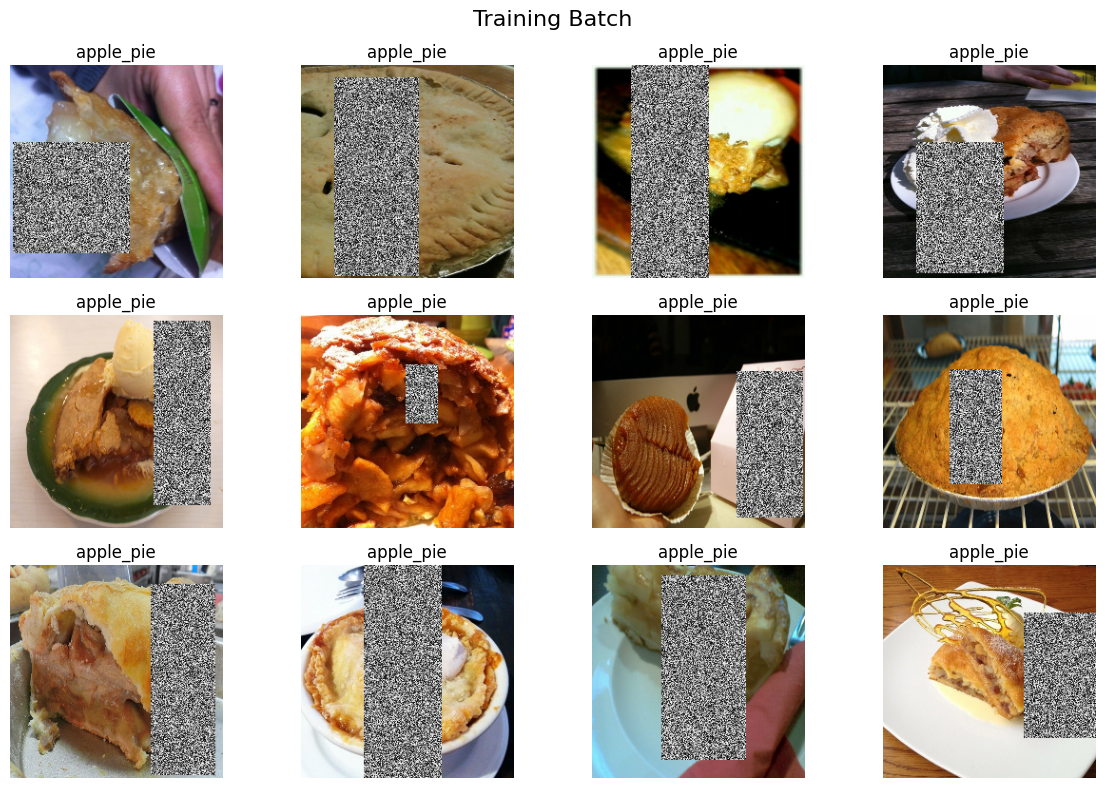

In [43]:
show_batch(test_ds_r, classes)

In [44]:
results = model.evaluate(test_ds_r)

395/395 [==============================] - 271s 683ms/step - loss: 1.4228 - accuracy: 0.7364 - top_5_accuracy: 0.9073
